#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        # self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        # value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        # value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), key)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [18]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 10
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [19]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [20]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [21]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12842762

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [22]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [23]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13342474

##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [23]:
%%time
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.78it/s]


Epoch : 1 - acc: 0.2677 - loss : 1.9727



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.3267 - test loss : 1.8595



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 2 - acc: 0.3343 - loss : 1.8103



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.3899 - test loss : 1.6691



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 3 - acc: 0.3711 - loss : 1.7112



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.4040 - test loss : 1.6403



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 4 - acc: 0.3959 - loss : 1.6469



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.4431 - test loss : 1.5402



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 7 - acc: 0.4421 - loss : 1.5321



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4621 - test loss : 1.4777



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 8 - acc: 0.4583 - loss : 1.4913



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.4896 - test loss : 1.4276



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 9 - acc: 0.4647 - loss : 1.4708



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.4755 - test loss : 1.4591



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 10 - acc: 0.4780 - loss : 1.4462



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.69it/s]


test acc: 0.4852 - test loss : 1.4296



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 11 - acc: 0.4874 - loss : 1.4279



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4966 - test loss : 1.4004



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 12 - acc: 0.4921 - loss : 1.4073



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5027 - test loss : 1.4057



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 13 - acc: 0.5020 - loss : 1.3897



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.5097 - test loss : 1.3761



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 14 - acc: 0.5061 - loss : 1.3724



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.64it/s]


test acc: 0.5130 - test loss : 1.3593



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 15 - acc: 0.5117 - loss : 1.3594



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.46it/s]


test acc: 0.5024 - test loss : 1.3948



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 16 - acc: 0.5156 - loss : 1.3460



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.5225 - test loss : 1.3381



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 17 - acc: 0.5254 - loss : 1.3210



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5095 - test loss : 1.3654



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 18 - acc: 0.5281 - loss : 1.3145



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.5266 - test loss : 1.3137



 60%|████████████████████████▋                | 118/196 [00:43<00:28,  2.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 74 - acc: 0.6651 - loss : 0.9396



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.6092 - test loss : 1.1601



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 75 - acc: 0.6666 - loss : 0.9369



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.51it/s]


test acc: 0.6063 - test loss : 1.1603



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 76 - acc: 0.6685 - loss : 0.9311



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.6026 - test loss : 1.1829



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 77 - acc: 0.6688 - loss : 0.9284



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.6066 - test loss : 1.1408



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 78 - acc: 0.6749 - loss : 0.9133



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5897 - test loss : 1.2089



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 79 - acc: 0.6756 - loss : 0.9163



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.80it/s]


test acc: 0.5911 - test loss : 1.2004



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 80 - acc: 0.6775 - loss : 0.9151



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.6037 - test loss : 1.1589



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 81 - acc: 0.6785 - loss : 0.9096



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.6044 - test loss : 1.1534



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 82 - acc: 0.6748 - loss : 0.9117



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.6185 - test loss : 1.1011



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 83 - acc: 0.6822 - loss : 0.8943



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.6032 - test loss : 1.1770



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 84 - acc: 0.6793 - loss : 0.8985



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5974 - test loss : 1.1967



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 85 - acc: 0.6831 - loss : 0.8914



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.42it/s]


test acc: 0.6054 - test loss : 1.1783



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 86 - acc: 0.6802 - loss : 0.8953



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.6062 - test loss : 1.1377



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 87 - acc: 0.6840 - loss : 0.8884



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.6105 - test loss : 1.1421



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 88 - acc: 0.6863 - loss : 0.8799



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.6101 - test loss : 1.1603



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 89 - acc: 0.6885 - loss : 0.8801



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.87it/s]


test acc: 0.6054 - test loss : 1.1567



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 90 - acc: 0.6890 - loss : 0.8727



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.6027 - test loss : 1.1710



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 91 - acc: 0.6912 - loss : 0.8706



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.6141 - test loss : 1.1332



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 92 - acc: 0.6885 - loss : 0.8748



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.5908 - test loss : 1.2128



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 93 - acc: 0.6922 - loss : 0.8684



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.6141 - test loss : 1.1390



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 94 - acc: 0.6968 - loss : 0.8576



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5959 - test loss : 1.2049



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 95 - acc: 0.6934 - loss : 0.8627



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.61it/s]


test acc: 0.5969 - test loss : 1.1966



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 96 - acc: 0.6968 - loss : 0.8501



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.6087 - test loss : 1.1728



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 97 - acc: 0.6969 - loss : 0.8521



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.6049 - test loss : 1.1752



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 98 - acc: 0.6999 - loss : 0.8406



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.39it/s]


test acc: 0.6092 - test loss : 1.1634



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.74it/s]


Epoch : 99 - acc: 0.7024 - loss : 0.8393



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.67it/s]


test acc: 0.6021 - test loss : 1.1750



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.74it/s]


Epoch : 100 - acc: 0.7011 - loss : 0.8414



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.66it/s]


test acc: 0.6024 - test loss : 1.2056

CPU times: user 1h 13min 44s, sys: 53min 31s, total: 2h 7min 16s
Wall time: 2h 7min 20s


In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12842762

##### CIFAR10 Dataset PRETRAINED

In [24]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.03it/s]


Epoch : 1 - acc: 0.2445 - loss : 1.9869



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.46it/s]


test acc: 0.2865 - test loss : 2.1285



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.97it/s]


Epoch : 2 - acc: 0.3859 - loss : 1.6495



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.47it/s]


test acc: 0.3903 - test loss : 1.7757



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.74it/s]


Epoch : 3 - acc: 0.4408 - loss : 1.5313



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.61it/s]


test acc: 0.4277 - test loss : 1.7406



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.73it/s]


Epoch : 4 - acc: 0.4716 - loss : 1.4611



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.30it/s]


test acc: 0.4686 - test loss : 1.6229



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.69it/s]


Epoch : 5 - acc: 0.4880 - loss : 1.4124



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.05it/s]


test acc: 0.4804 - test loss : 1.5927



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.77it/s]


Epoch : 6 - acc: 0.5004 - loss : 1.3881



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.06it/s]


test acc: 0.4459 - test loss : 1.7806



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.88it/s]


Epoch : 7 - acc: 0.5172 - loss : 1.3478



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.72it/s]


test acc: 0.4740 - test loss : 1.6808



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.68it/s]


Epoch : 8 - acc: 0.5275 - loss : 1.3230



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.35it/s]


test acc: 0.4705 - test loss : 1.6875



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.81it/s]


Epoch : 9 - acc: 0.5340 - loss : 1.2919



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.80it/s]


test acc: 0.5015 - test loss : 1.5286



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.68it/s]


Epoch : 10 - acc: 0.5486 - loss : 1.2616



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.21it/s]


test acc: 0.4988 - test loss : 1.6035



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.80it/s]


Epoch : 11 - acc: 0.5572 - loss : 1.2422



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.11it/s]


test acc: 0.4890 - test loss : 1.6629



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.46it/s]


Epoch : 12 - acc: 0.5641 - loss : 1.2251



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.66it/s]


test acc: 0.5074 - test loss : 1.5934



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.50it/s]


Epoch : 13 - acc: 0.5683 - loss : 1.2118



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.93it/s]


test acc: 0.5266 - test loss : 1.4776



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.83it/s]


Epoch : 14 - acc: 0.5780 - loss : 1.1817



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.83it/s]


test acc: 0.5098 - test loss : 1.5787



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.98it/s]


Epoch : 15 - acc: 0.5814 - loss : 1.1758



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.48it/s]


test acc: 0.5246 - test loss : 1.5125



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.68it/s]


Epoch : 16 - acc: 0.5909 - loss : 1.1559



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.19it/s]


test acc: 0.5276 - test loss : 1.5203



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.82it/s]


Epoch : 17 - acc: 0.5953 - loss : 1.1364



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.49it/s]


test acc: 0.5229 - test loss : 1.5177



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.85it/s]


Epoch : 18 - acc: 0.6028 - loss : 1.1161



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.62it/s]


test acc: 0.5429 - test loss : 1.4655



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.74it/s]


Epoch : 19 - acc: 0.6060 - loss : 1.1126



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.23it/s]


test acc: 0.5478 - test loss : 1.4765



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.74it/s]


Epoch : 20 - acc: 0.6090 - loss : 1.1030



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.91it/s]


test acc: 0.5347 - test loss : 1.4634



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.71it/s]


Epoch : 21 - acc: 0.6133 - loss : 1.0882



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.54it/s]


test acc: 0.5593 - test loss : 1.4010



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.91it/s]


Epoch : 22 - acc: 0.6177 - loss : 1.0814



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.07it/s]


test acc: 0.5519 - test loss : 1.3982



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.86it/s]


Epoch : 23 - acc: 0.6235 - loss : 1.0666



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.63it/s]


test acc: 0.5407 - test loss : 1.5292



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.82it/s]


Epoch : 24 - acc: 0.6282 - loss : 1.0561



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.74it/s]


test acc: 0.5687 - test loss : 1.3210



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.71it/s]


Epoch : 25 - acc: 0.6304 - loss : 1.0446



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.83it/s]


test acc: 0.5537 - test loss : 1.4491



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.45it/s]


Epoch : 26 - acc: 0.6353 - loss : 1.0411



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.95it/s]


test acc: 0.5419 - test loss : 1.5451



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.71it/s]


Epoch : 27 - acc: 0.6362 - loss : 1.0319



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.22it/s]


test acc: 0.5602 - test loss : 1.4049



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.66it/s]


Epoch : 28 - acc: 0.6405 - loss : 1.0153



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.75it/s]


test acc: 0.5517 - test loss : 1.4278



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.80it/s]


Epoch : 29 - acc: 0.6473 - loss : 1.0061



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.97it/s]


test acc: 0.5689 - test loss : 1.3964



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.01it/s]


Epoch : 30 - acc: 0.6451 - loss : 0.9977



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.46it/s]


test acc: 0.5720 - test loss : 1.3975



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.68it/s]


Epoch : 31 - acc: 0.6525 - loss : 0.9857



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.15it/s]


test acc: 0.5691 - test loss : 1.3728



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.80it/s]


Epoch : 32 - acc: 0.6564 - loss : 0.9808



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.29it/s]


test acc: 0.5717 - test loss : 1.3270



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.00it/s]


Epoch : 33 - acc: 0.6549 - loss : 0.9797



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.89it/s]


test acc: 0.5771 - test loss : 1.3484



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.77it/s]


Epoch : 34 - acc: 0.6568 - loss : 0.9763



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.66it/s]


test acc: 0.5815 - test loss : 1.3255



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.03it/s]


Epoch : 35 - acc: 0.6585 - loss : 0.9682



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.92it/s]


test acc: 0.5724 - test loss : 1.3469



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.76it/s]


Epoch : 36 - acc: 0.6584 - loss : 0.9675



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.34it/s]


test acc: 0.5759 - test loss : 1.3841



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.65it/s]


Epoch : 37 - acc: 0.6659 - loss : 0.9482



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.98it/s]


test acc: 0.5620 - test loss : 1.4242



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.84it/s]


Epoch : 38 - acc: 0.6650 - loss : 0.9438



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.54it/s]


test acc: 0.5829 - test loss : 1.3446



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.70it/s]


Epoch : 39 - acc: 0.6729 - loss : 0.9308



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.85it/s]


test acc: 0.5727 - test loss : 1.3705



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.68it/s]


Epoch : 40 - acc: 0.6732 - loss : 0.9281



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.62it/s]


test acc: 0.5658 - test loss : 1.4327



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.47it/s]


Epoch : 41 - acc: 0.6728 - loss : 0.9274



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.69it/s]


test acc: 0.5704 - test loss : 1.3528



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.66it/s]


Epoch : 42 - acc: 0.6752 - loss : 0.9246



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.20it/s]


test acc: 0.5675 - test loss : 1.3854



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.86it/s]


Epoch : 43 - acc: 0.6777 - loss : 0.9114



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.52it/s]


test acc: 0.5674 - test loss : 1.4247



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 18.08it/s]


Epoch : 44 - acc: 0.6826 - loss : 0.8966



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.14it/s]


test acc: 0.5888 - test loss : 1.3258



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.69it/s]


Epoch : 45 - acc: 0.6830 - loss : 0.9003



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.52it/s]


test acc: 0.5873 - test loss : 1.3367



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.76it/s]


Epoch : 46 - acc: 0.6847 - loss : 0.8987



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.86it/s]


test acc: 0.5970 - test loss : 1.2915



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.85it/s]


Epoch : 47 - acc: 0.6879 - loss : 0.8893



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.55it/s]


test acc: 0.5996 - test loss : 1.2623



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.65it/s]


Epoch : 48 - acc: 0.6849 - loss : 0.8868



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.75it/s]


test acc: 0.6045 - test loss : 1.2315



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.84it/s]


Epoch : 49 - acc: 0.6921 - loss : 0.8721



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.66it/s]


test acc: 0.5860 - test loss : 1.3398



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.88it/s]


Epoch : 50 - acc: 0.6940 - loss : 0.8665



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.26it/s]


test acc: 0.5944 - test loss : 1.2916



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.89it/s]


Epoch : 51 - acc: 0.6938 - loss : 0.8719



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.75it/s]


test acc: 0.5850 - test loss : 1.3441



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.97it/s]


Epoch : 52 - acc: 0.6971 - loss : 0.8544



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.56it/s]


test acc: 0.6023 - test loss : 1.2886



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.72it/s]


Epoch : 53 - acc: 0.6962 - loss : 0.8621



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.93it/s]


test acc: 0.6036 - test loss : 1.2934



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.42it/s]


Epoch : 54 - acc: 0.7018 - loss : 0.8486



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.03it/s]


test acc: 0.6031 - test loss : 1.2486



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.65it/s]


Epoch : 55 - acc: 0.7020 - loss : 0.8475



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.02it/s]


test acc: 0.6061 - test loss : 1.2304



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.69it/s]


Epoch : 56 - acc: 0.7001 - loss : 0.8513



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.22it/s]


test acc: 0.5941 - test loss : 1.2694



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.80it/s]


Epoch : 57 - acc: 0.7015 - loss : 0.8401



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.82it/s]


test acc: 0.5978 - test loss : 1.2581



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.58it/s]


Epoch : 58 - acc: 0.7109 - loss : 0.8261



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.47it/s]


test acc: 0.6043 - test loss : 1.2234



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.60it/s]


Epoch : 59 - acc: 0.7058 - loss : 0.8328



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.03it/s]


test acc: 0.6097 - test loss : 1.2527



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.93it/s]


Epoch : 60 - acc: 0.7087 - loss : 0.8271



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.86it/s]


test acc: 0.6157 - test loss : 1.2210



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.78it/s]


Epoch : 61 - acc: 0.7114 - loss : 0.8200



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.30it/s]


test acc: 0.5972 - test loss : 1.2528



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.70it/s]


Epoch : 62 - acc: 0.7102 - loss : 0.8173



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.56it/s]


test acc: 0.6041 - test loss : 1.3050



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.63it/s]


Epoch : 63 - acc: 0.7133 - loss : 0.8153



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.67it/s]


test acc: 0.6133 - test loss : 1.2148



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.85it/s]


Epoch : 64 - acc: 0.7173 - loss : 0.8038



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 43.65it/s]


test acc: 0.6110 - test loss : 1.2422



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.86it/s]


Epoch : 65 - acc: 0.7197 - loss : 0.7979



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.95it/s]


test acc: 0.6106 - test loss : 1.2410



100%|█████████████████████████████████████████| 196/196 [00:11<00:00, 17.53it/s]


Epoch : 66 - acc: 0.7193 - loss : 0.7988



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 41.11it/s]


test acc: 0.6101 - test loss : 1.2585



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 17.86it/s]


Epoch : 67 - acc: 0.7202 - loss : 0.7932



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.61it/s]


test acc: 0.6080 - test loss : 1.2850



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch : 68 - acc: 0.7243 - loss : 0.7807



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.20it/s]


test acc: 0.6141 - test loss : 1.2017



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.84it/s]


Epoch : 69 - acc: 0.7242 - loss : 0.7858



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.07it/s]


test acc: 0.6129 - test loss : 1.2386



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.94it/s]


Epoch : 70 - acc: 0.7277 - loss : 0.7740



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.28it/s]


test acc: 0.6283 - test loss : 1.1863



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.22it/s]


Epoch : 71 - acc: 0.7277 - loss : 0.7741



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.32it/s]


test acc: 0.6030 - test loss : 1.3104



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 72 - acc: 0.7241 - loss : 0.7818



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.61it/s]


test acc: 0.6002 - test loss : 1.2862



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 73 - acc: 0.7282 - loss : 0.7716



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.19it/s]


test acc: 0.6211 - test loss : 1.1893



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.94it/s]


Epoch : 74 - acc: 0.7299 - loss : 0.7642



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.04it/s]


test acc: 0.6197 - test loss : 1.2362



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch : 75 - acc: 0.7309 - loss : 0.7660



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.48it/s]


test acc: 0.6209 - test loss : 1.1992



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.13it/s]


Epoch : 76 - acc: 0.7339 - loss : 0.7573



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.77it/s]


test acc: 0.6533 - test loss : 1.0778



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 77 - acc: 0.7340 - loss : 0.7621



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.08it/s]


test acc: 0.6271 - test loss : 1.1838



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.18it/s]


Epoch : 78 - acc: 0.7359 - loss : 0.7485



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.26it/s]


test acc: 0.6282 - test loss : 1.1756



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.98it/s]


Epoch : 79 - acc: 0.7394 - loss : 0.7425



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.14it/s]


test acc: 0.6341 - test loss : 1.2071



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.84it/s]


Epoch : 80 - acc: 0.7392 - loss : 0.7380



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.64it/s]


test acc: 0.5961 - test loss : 1.3314



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.10it/s]


Epoch : 81 - acc: 0.7389 - loss : 0.7398



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.63it/s]


test acc: 0.6222 - test loss : 1.2273



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.31it/s]


Epoch : 82 - acc: 0.7397 - loss : 0.7364



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.56it/s]


test acc: 0.6144 - test loss : 1.2605



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.35it/s]


Epoch : 83 - acc: 0.7431 - loss : 0.7293



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.62it/s]


test acc: 0.6017 - test loss : 1.3091



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.68it/s]


Epoch : 84 - acc: 0.7449 - loss : 0.7248



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.63it/s]


test acc: 0.6103 - test loss : 1.3064



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.50it/s]


Epoch : 85 - acc: 0.7415 - loss : 0.7333



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.01it/s]


test acc: 0.5993 - test loss : 1.2947



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.07it/s]


Epoch : 86 - acc: 0.7441 - loss : 0.7254



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.96it/s]


test acc: 0.6208 - test loss : 1.2415



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.67it/s]


Epoch : 87 - acc: 0.7469 - loss : 0.7165



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.76it/s]


test acc: 0.6384 - test loss : 1.1343



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.69it/s]


Epoch : 88 - acc: 0.7458 - loss : 0.7236



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.56it/s]


test acc: 0.6378 - test loss : 1.1318



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch : 89 - acc: 0.7522 - loss : 0.7090



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.27it/s]


test acc: 0.6417 - test loss : 1.1517



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.47it/s]


Epoch : 90 - acc: 0.7507 - loss : 0.7056



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.43it/s]


test acc: 0.6353 - test loss : 1.1856



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.63it/s]


Epoch : 91 - acc: 0.7514 - loss : 0.7079



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.19it/s]


test acc: 0.6088 - test loss : 1.3119



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch : 92 - acc: 0.7505 - loss : 0.7072



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.95it/s]


test acc: 0.6188 - test loss : 1.2018



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 93 - acc: 0.7551 - loss : 0.6979



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.87it/s]


test acc: 0.6249 - test loss : 1.2596



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.88it/s]


Epoch : 94 - acc: 0.7540 - loss : 0.6959



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.77it/s]


test acc: 0.6304 - test loss : 1.1985



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.42it/s]


Epoch : 95 - acc: 0.7583 - loss : 0.6854



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.34it/s]


test acc: 0.6442 - test loss : 1.1606



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.76it/s]


Epoch : 96 - acc: 0.7595 - loss : 0.6864



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.21it/s]


test acc: 0.6235 - test loss : 1.2710



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.27it/s]


Epoch : 97 - acc: 0.7545 - loss : 0.6911



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.00it/s]


test acc: 0.6169 - test loss : 1.2704



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.03it/s]


Epoch : 98 - acc: 0.7597 - loss : 0.6775



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.16it/s]


test acc: 0.6354 - test loss : 1.2033



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.18it/s]


Epoch : 99 - acc: 0.7600 - loss : 0.6790



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.85it/s]


test acc: 0.6273 - test loss : 1.2589



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.80it/s]


Epoch : 100 - acc: 0.7634 - loss : 0.6709



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.77it/s]


test acc: 0.6290 - test loss : 1.2304



In [25]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13342474

##### CIFAR100 Dataset

In [23]:
%%time
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 3 - acc: 0.1338 - loss : 3.6945



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.1532 - test loss : 3.5935



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 4 - acc: 0.1582 - loss : 3.5487



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.1779 - test loss : 3.4467



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 5 - acc: 0.1783 - loss : 3.4201



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.2031 - test loss : 3.3260



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 6 - acc: 0.1996 - loss : 3.3197



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.2220 - test loss : 3.2300



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 7 - acc: 0.2141 - loss : 3.2246



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.2289 - test loss : 3.1955



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 8 - acc: 0.2246 - loss : 3.1580



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.2450 - test loss : 3.1046



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 9 - acc: 0.2405 - loss : 3.0827



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.2572 - test loss : 3.0427



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 10 - acc: 0.2488 - loss : 3.0196



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.65it/s]


test acc: 0.2524 - test loss : 3.0172



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 11 - acc: 0.2599 - loss : 2.9653



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.37it/s]


test acc: 0.2727 - test loss : 2.9395



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 12 - acc: 0.2696 - loss : 2.9173



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.2818 - test loss : 2.9235



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 13 - acc: 0.2791 - loss : 2.8661



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.2791 - test loss : 2.9039



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 14 - acc: 0.2874 - loss : 2.8231



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.2875 - test loss : 2.8505



 54%|██████████████████████▏                  | 106/196 [00:38<00:29,  3.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 52 - acc: 0.5313 - loss : 1.6855



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.51it/s]


test acc: 0.3986 - test loss : 2.4768



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 54 - acc: 0.5446 - loss : 1.6331



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.4092 - test loss : 2.4512



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 55 - acc: 0.5511 - loss : 1.6072



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.4040 - test loss : 2.4570



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 56 - acc: 0.5560 - loss : 1.5796



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4052 - test loss : 2.4884



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 57 - acc: 0.5567 - loss : 1.5582



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.4026 - test loss : 2.4777



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 58 - acc: 0.5671 - loss : 1.5314



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.41it/s]


test acc: 0.4092 - test loss : 2.4737



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 59 - acc: 0.5746 - loss : 1.4974



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.73it/s]


test acc: 0.4091 - test loss : 2.4761



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 60 - acc: 0.5778 - loss : 1.4843



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.4038 - test loss : 2.5062



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 61 - acc: 0.5882 - loss : 1.4459



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.4077 - test loss : 2.5450



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 62 - acc: 0.5905 - loss : 1.4257



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.4081 - test loss : 2.4966



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 63 - acc: 0.5974 - loss : 1.3943



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.60it/s]


test acc: 0.4068 - test loss : 2.5252



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 64 - acc: 0.6029 - loss : 1.3767



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.4175 - test loss : 2.5009



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 65 - acc: 0.6148 - loss : 1.3417



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.4051 - test loss : 2.5604



 88%|████████████████████████████████████▏    | 173/196 [01:02<00:08,  2.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 81 - acc: 0.7177 - loss : 0.9313



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.43it/s]


test acc: 0.4183 - test loss : 2.7279



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 82 - acc: 0.7258 - loss : 0.9030



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.4138 - test loss : 2.7872



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 83 - acc: 0.7286 - loss : 0.8899



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.4164 - test loss : 2.7841



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 84 - acc: 0.7367 - loss : 0.8671



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.4175 - test loss : 2.7707



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 85 - acc: 0.7426 - loss : 0.8415



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.4198 - test loss : 2.7986



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 86 - acc: 0.7518 - loss : 0.8160



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.4202 - test loss : 2.8180



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 87 - acc: 0.7559 - loss : 0.8019



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.4180 - test loss : 2.8361



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 88 - acc: 0.7619 - loss : 0.7768



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.4178 - test loss : 2.8522



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 89 - acc: 0.7656 - loss : 0.7550



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.99it/s]


test acc: 0.4173 - test loss : 2.8988



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 90 - acc: 0.7766 - loss : 0.7286



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.4129 - test loss : 2.9425



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 91 - acc: 0.7778 - loss : 0.7223



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4217 - test loss : 2.9331



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 92 - acc: 0.7856 - loss : 0.6929



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4261 - test loss : 2.9514



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 93 - acc: 0.7889 - loss : 0.6757



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.4212 - test loss : 2.9521



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 94 - acc: 0.7958 - loss : 0.6520



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.4216 - test loss : 3.0306



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 95 - acc: 0.8006 - loss : 0.6378



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.4193 - test loss : 2.9867



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 96 - acc: 0.8087 - loss : 0.6205



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.4183 - test loss : 3.0754



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 97 - acc: 0.8121 - loss : 0.6034



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.4174 - test loss : 3.0673



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 98 - acc: 0.8186 - loss : 0.5775



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.4196 - test loss : 3.0225



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 99 - acc: 0.8249 - loss : 0.5613



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.72it/s]


test acc: 0.4148 - test loss : 3.1600



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 100 - acc: 0.8240 - loss : 0.5563



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.4217 - test loss : 3.0988

CPU times: user 1h 14min 32s, sys: 52min 47s, total: 2h 7min 20s
Wall time: 2h 7min 23s


In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12865892

##### Saving accuracy

In [27]:
max(train_accs)

0.7023875713348389

In [28]:
max(test_accs)

0.6184569001197815

In [25]:
import csv

dataset = 'cifar10'
path = './results/'
model_name = 'light-time'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

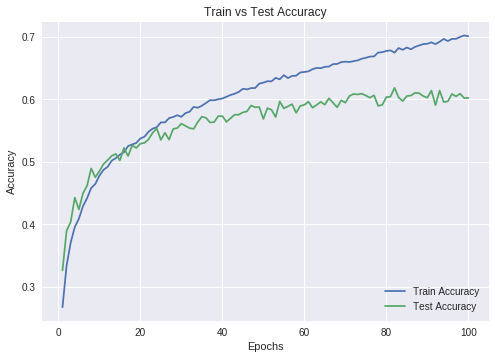

In [26]:
#CIFAR10
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

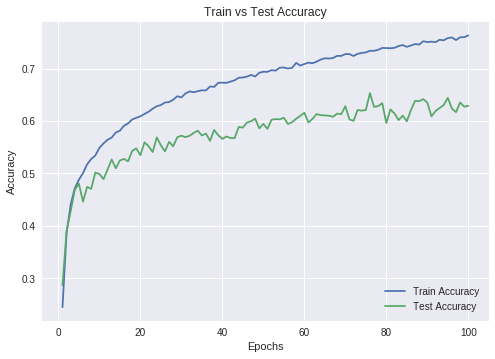

In [27]:
#CIFAR10 pretrained
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

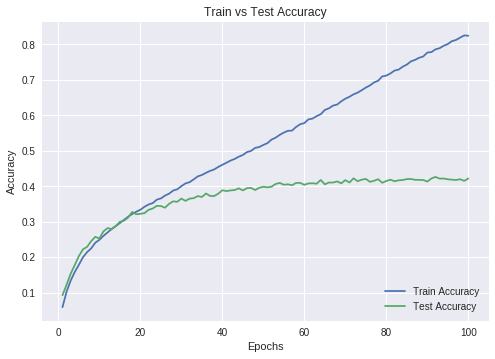

In [25]:
#CIFAR100
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')